In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[10]:
import PySimpleGUI as sg
import csv, os
import pandas as pd
import numpy as np
import community
from networkx.algorithms import centrality
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.pyplot import figure, text
from sklearn.metrics.cluster import normalized_mutual_info_score
from networkx.algorithms import community
from networkx.algorithms.community.centrality import girvan_newman

# In[23]:
# Functions for plotting 

# conductance for undirected and directed graph

import networkx as nx

def directed_conductance(graph, communities):
    external_edges = 0
    internal_edges = 0
    for node in graph.nodes():
        for neighbor in graph.neighbors(node):
            if communities[node] != communities[neighbor]:
                external_edges += 1
            else:
                internal_edges += 1
    min_out_degree_sum = float("inf")
    min_in_degree_sum = float("inf")
    for community in set(communities.values()):
        community_nodes = [node for node in graph.nodes() if communities[node] == community]
        if graph.is_directed():
            out_degree_sum = sum(graph.out_degree(node) for node in community_nodes)
            in_degree_sum = sum(graph.in_degree(node) for node in community_nodes)
            min_out_degree_sum = min(min_out_degree_sum, out_degree_sum)
            min_in_degree_sum = min(min_in_degree_sum, in_degree_sum)
        else:
            degree_sum = sum(graph.degree(node) for node in community_nodes)
            min_out_degree_sum = min(min_out_degree_sum, degree_sum)
            min_in_degree_sum = min(min_in_degree_sum, degree_sum)
    boundary_out = set()
    boundary_in = set()
    for node in graph.nodes():
        for neighbor in graph.neighbors(node):
            if communities[node] != communities[neighbor]:
                if graph.is_directed():
                    if communities[node] < communities[neighbor]:
                        boundary_out.add((node, neighbor))
                    else:
                        boundary_in.add((neighbor, node))
                else:
                    boundary_out.add((node, neighbor))
                    boundary_out.add((neighbor, node))
    external_out_edges = len(boundary_out)
    external_in_edges = len(boundary_in)
    conductance_out = external_out_edges / min_out_degree_sum
    conductance_in = external_in_edges / min_in_degree_sum
    conductance = max(conductance_out, conductance_in)
    print(conductance)
    return conductance


# eigenvector centrality (Handles directed and undirected)
import networkx as nx

def convert_eigenvector_centrality(G):
    # Step 1: Compute eigenvector centrality of undirected graph
    undirected_centrality = nx.eigenvector_centrality(G)

    # Step 2: Create directed graph from undirected graph
    D = G.to_directed()

    # Step 3: Compute average of eigenvector centrality values for each node in D
    directed_centrality = {}
    for node in D.nodes():
        neighbors = G.neighbors(node)
        neighbor_centrality = [undirected_centrality[n] for n in neighbors]
        directed_centrality[node] = sum(neighbor_centrality) / len(neighbor_centrality)

    # Step 4: Normalize resulting vector
    centrality_sum = sum(directed_centrality.values())
    directed_centrality = {node: centrality / centrality_sum for node, centrality in directed_centrality.items()}

    return directed_centrality

# closeness centrality (Handles directed and undirected)
def calculate_closeness_centrality(G):
    if G.is_directed():
        centrality = nx.closeness_centrality(G, wf_improved=True)
    else:
        centrality = nx.closeness_centrality(G)
    return centrality

# degree centrality (Handles directed and undirected)
def calculate_degree_centrality(G):
    if G.is_directed():
        degree_centrality = nx.out_degree_centrality(G)
    else:
       # centrality = nx.degree_centrality(G)
        degree_centrality = centrality.degree_centrality(G)

    return degree_centrality

def create_plot(G, num):
    if num == 0: # For drawing the original plot
        figure(figsize=(10,10))
        node_color =  [G.degree(n)*20 for n in G]
        node_size = [G.degree(n)*20 for n in G]
        pos = nx.kamada_kawai_layout(G)
        nx.draw_networkx_nodes(G, pos, node_color = node_color , node_size=node_size, alpha = 1)
        nx.draw_networkx_edges(G, pos, alpha = 0.5)
        nx.draw_networkx_labels(G, pos, font_size = 7, font_family = 'sans-serif')
    if num == 1: # For drawing the plot of the betweenness centrality
        node_size = [v * 10000 for v in nx.betweenness_centrality(G).values()]
        #filtered_nodes = [n for n, c in nx.betweenness_centrality(G).items() if c >= 0.008]
        figure(figsize=(10,10))
        betweenness_centrality = nx.betweenness_centrality(G)
        #print(sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[0:10])
        x = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[0:1]
        value = x[0][1]
        #print(value)
        # create a colormap for the nodes based on their betweenness centrality
        color_map = []
        for node in G:
            if betweenness_centrality[node] == value:
                color_map.append('red')
            else:
                color_map.append('white')
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        # draw the graph with nodes colored by betweenness centrality
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gray", node_color=color_map, font_size=8,
                    font_color="black")
    if num == 2: # For drawing the plot of the closeness centrality
        node_size = [v * 100 for v in calculate_closeness_centrality(G).values()]
        figure(figsize=(10,10))
        #print(sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[0:10])
        # create a colormap for the nodes based on their closeness_centrality 
        closeness_centrality=calculate_closeness_centrality(G)
        
        x = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[0:1]
        value = x[0][1]
        
        color_map = []
        for node in G:
            if closeness_centrality[node] == value:
                color_map.append('green')
            else:
                color_map.append('white')
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        # draw the graph with nodes colored by closeness_centrality 
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gainsboro", node_color=color_map, font_size=8,
                    font_color="black")
    if num == 3: # For drawing the plot of the eigenvector centrality
        node_size = [v * 1000 for v in convert_eigenvector_centrality(G).values()]
        figure(figsize=(10,10))
        eigenvector_centrality = convert_eigenvector_centrality(G)
        #print(sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[0:10])
        # create a colormap for the nodes based on their eigenvector 
        
        x = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[0:1]
        value = x[0][1]
        #print(value)
        color_map = []
        for node in G:
            if eigenvector_centrality[node] == value:
                color_map.append('yellow')
            else:
                color_map.append('white')
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        node_size = [v * 1000 for v in eigenvector_centrality.values()]

        # draw the graph with nodes colored by eigenvector 
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gainsboro", node_color=color_map, font_size=8,
                    font_color="black")

    if num == 4: # For drawing the plot of the degree centrality
        node_size = [v * 100 for v in calculate_degree_centrality(G).values()]
        figure(figsize=(10,10))
        # compute the degree_centrality for each node
        degree_centrality = calculate_degree_centrality(G)
        #print(sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[0:10])
        # create a colormap for the nodes based on their degree_centrality
        
        x = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[0:1]
        value = x[0][1]
        
        color_map = []
        for node in G:
            if degree_centrality[node] == value:
                color_map.append('blue')
            else:
                color_map.append('white')
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        # draw the graph with nodes colored by degree_centrality 
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gainsboro", node_color=color_map, font_size=8,
                    font_color="black")
    if num == 5: # For drawing the plot after adjusting node size based on node degree
        degrees = dict(G.degree())
        node_size = [degrees[n] for n in G.nodes()]
        figure(figsize=(10,10))
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gainsboro", node_color='yellow', font_size=8,
            font_color="black")
    if num == 6: # For drawing the plot after adjusting edge based on weight
        figure(figsize=(15,15))
        
        edge_weights = nx.get_edge_attributes(G1, 'weight')
        
        edge_widths = [v * 0.02  for v in edge_weights.values()]
        
        pos = nx.fruchterman_reingold_layout(G, k=3.1)
        
        edges, weights = zip(*nx.get_edge_attributes(G, 'weight').items())
        
        nx.draw_networkx_nodes(G, pos, node_size=10)
        nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color=weights)
        nx.draw_networkx_labels(G, pos)
        
    if num == 7: # For drawing the plot of page rank
        pagerank_scores = nx.pagerank(G, alpha=0.85,max_iter=100)
        #print(sorted(pagerank_scores.items(), key=lambda x: x[1], reverse=True)[0:10])
        color_map=[]
        max_score = max(pagerank_scores.values())
        filtered_nodes = [node for node, score in pagerank_scores.items() if score == max_score]
        for node in G:
            if node in filtered_nodes:
                color_map.append('red')
            else:
                color_map.append('green')
        pos = nx.fruchterman_reingold_layout(G, k=1.0)
        figure(figsize=(15,10))
        node_size = [v * 100000 for v in pagerank_scores.values()]
        nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gray", node_color=color_map, font_size=10,
                    font_color="black")
    if num == 8: # Run the Louvain algorithm
        # Create a sample network
        #df = pd.read_csv("primaryschool_Edges.csv")
        # Create a graph from the dataset
       # G = nx.from_pandas_edgelist(df, source="Source", target="Target")
        # Run the Louvain algorithm
        partition = community.best_partition(G)
        #print(partition)
        fig = plt.figure(figsize=(15,15))
        fig.clear()
        # Draw the graph with the nodes colored by their community
        pos = nx.fruchterman_reingold_layout(G,k=1.0)
        cmap = plt.get_cmap('viridis')
        nx.draw_networkx(G, pos, node_size=100,with_labels = False, cmap=cmap, node_color=list(partition.values()))
        #nx.draw_networkx_edges(G, pos, alpha=0.8)
#         node_size = [v * 100000 for v in partition.values()]
#         nx.draw(G, pos = pos, node_size = node_size, with_labels = True, edge_color="gray", node_color=list(partition.values(), font_size=10,
#                     font_color="black")   
    return plt.gcf()

def draw_figure(canvas, figure):
    figure_canvas_agg = FigureCanvasTkAgg(figure, canvas)
    figure_canvas_agg.draw()
    figure_canvas_agg.get_tk_widget().place(relx = 0.5, rely = 0.5, anchor = 'center')
    return figure_canvas_agg



In [2]:
# Function for returning window where the output of the betweenness centrality is viewed as a plot

def bc_figure(G):
    
    bc = nx.betweenness_centrality(G)

    data = [[node, bc[node]] for node in bc]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Node ID', 'Betweenness Centrality'], key = "-BCTABLE-", col_widths = 40, size=(50, 20))],
        [sg.Button("Filter Node of MAXIMUM betweenness", button_color = 'White', key = '-MAXBC-', size=(50, 3))],
        [sg.Button("Filter Node of MINIMUM betweenness", button_color = 'White', key = '-MINBC-', size=(50, 3))]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-BC_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    bc_window = sg.Window('Betweenness Centrality Measure', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(bc_window["-BC_CANVAS-"].TKCanvas, create_plot(G, 1))

    while True:
        event,values = bc_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
        if event == "-MAXBC-":
            #bc = nx.betweenness_centrality(G)
            #data = [[node, bc[node]] for node in bc]
            data.sort(key=lambda x: x[1], reverse=True)
            max_bc_node = data[0]
            sg.popup("Node " + str(max_bc_node[0]) + " of betweenness centrality value " + str(max_bc_node[1]), keep_on_top=True, title = "Maximum Betweenness Centrality")
        if event == "-MINBC-":
            data.sort(key=lambda x: x[1], reverse=True)
            min_bc_node = data[-1]
            sg.popup("Node " + str(min_bc_node[0]) + " of betweenness centrality value " + str(min_bc_node[1]), keep_on_top=True, title = "Minimum Betweenness Centrality")
    bc_window.close()

# In[25]:


# Function for returning window where the output of the closeness centrality is viewed as a plot

def cc_figure(G):
    
    cc = calculate_closeness_centrality(G)

    data = [[node, cc[node]] for node in cc]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Node ID', 'Closeness Centrality'], key = "-CCTABLE-", col_widths = 40, size=(50, 20))],
        [sg.Button("Filter Node of MAXIMUM closeness", button_color = 'White', key = '-MAXCC-', size=(50, 3))],
        [sg.Button("Filter Node of MINIMUM closeness", button_color = 'White', key = '-MINCC-', size=(50, 3))]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-CC_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    cc_window = sg.Window('Closeness Centrality Measure', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(cc_window["-CC_CANVAS-"].TKCanvas, create_plot(G, 2))

    while True:
        event,values = cc_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
        if event == "-MAXCC-":
            #bc = nx.closeness_centrality(G)
            #data = [[node, bc[node]] for node in bc]
            data.sort(key=lambda x: x[1], reverse=True)
            max_cc_node = data[0]
            sg.popup("Node " + str(max_cc_node[0]) + " of closeness centrality value " + str(max_cc_node[1]), keep_on_top=True, title = "Maximum Closeness Centrality")
        if event == "-MINCC-":
            data.sort(key=lambda x: x[1], reverse=True)
            min_cc_node = data[-1]
            sg.popup("Node " + str(min_cc_node[0]) + " of closeness centrality value " + str(min_cc_node[1]), keep_on_top=True, title = "Minimum Closeness Centrality")
    cc_window.close()
# In[26]:


# Function for returning window where the output of the eigenvector centrality is viewed as a plot

def ec_figure(G):
    
    ec = convert_eigenvector_centrality(G)
        
    data = [[node, ec[node]] for node in ec]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Node ID', 'Eigenvector Centrality'], key = "-ECTABLE-", col_widths = 40, size=(50, 20))],
        [sg.Button("Filter Node of MAXIMUM eigenvector", button_color = 'White', key = '-MAXEC-', size=(50, 3))],
        [sg.Button("Filter Node of MINIMUM eigenvector", button_color = 'White', key = '-MINEC-', size=(50, 3))]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-EC_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    ec_window = sg.Window('Eigenvector Centrality Measure', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(ec_window["-EC_CANVAS-"].TKCanvas, create_plot(G, 3))

    while True:
        event,values = ec_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
        if event == "-MAXEC-":
            #bc = nx.eigenvector_centrality(G)
            #data = [[node, ec[node]] for node in ec]
            data.sort(key=lambda x: x[1], reverse=True)
            max_ec_node = data[0]
            sg.popup("Node " + str(max_ec_node[0]) + " of eigenvector centrailty value " + str(max_ec_node[1]), keep_on_top=True, title = "Maximum Eigenvector Centrality")
        if event == "-MINEC-":
            data.sort(key=lambda x: x[1], reverse=True)
            min_ec_node = data[-1]
            sg.popup("Node " + str(min_ec_node[0]) + " of eigenvector centrality value " + str(min_ec_node[1]), keep_on_top=True, title = "Minimum Eigenvector Centrality")
    ec_window.close()


# In[27]:


# Function for returning window where the output of the degree centrality is viewed as a plot

def dc_figure(G):
    
    dc = calculate_degree_centrality(G)

    data = [[node, dc[node]] for node in dc]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Node ID', 'Degree Centrality'], key = "-DCTABLE-", col_widths = 40, size=(50, 20))],
        [sg.Button("Filter Node of MAXIMUM degree", button_color = 'White', key = '-MAXDC-', size=(50, 3))],
        [sg.Button("Filter Node of MINIMUM degree", button_color = 'White', key = '-MINDC-', size=(50, 3))]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-DC_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    dc_window = sg.Window('Degree Centrality Measure', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(dc_window["-DC_CANVAS-"].TKCanvas, create_plot(G, 4))

    while True:
        event,values = dc_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
        if event == "-MAXDC-":
            data.sort(key=lambda x: x[1], reverse=True)
            max_dc_node = data[0]
            sg.popup("Node " + str(max_dc_node[0]) + " of degree centrailty value " + str(max_dc_node[1]), keep_on_top=True, title = "Maximum Degree Centrality")
        if event == "-MINDC-":
            data.sort(key=lambda x: x[1], reverse=True)
            min_dc_node = data[-1]
            sg.popup("Node " + str(min_dc_node[0]) + " of degree centrality value " + str(min_dc_node[1]), keep_on_top=True, title = "Minimum Degree Centrality")
    dc_window.close()


# In[28]:


# Function for returning window where the output of adjusting node degree is viewed as a plot

def nd_figure(G, directed):
    
    data = ""
    
    if directed:
        in_degrees = dict(G.in_degree())
        out_degrees = dict(G.out_degree())

        # Create a table of the degrees
        table_data = []
        for node in G.nodes():
             table_data.append([node, in_degrees.get(node, 0), out_degrees.get(node, 0)])
        data = pd.DataFrame(table_data, columns=['Node', 'In-degree', 'Out-degree'])
    else:
        degrees = dict(G.degree())
        table_data = [[node, degrees[node]] for node in degrees]

        table_data.sort(key=lambda x: x[1], reverse=True)
        data = pd.DataFrame(table_data, columns=['Node ID', 'Node Degree'])
        
    col_1 = [
        [
            sg.Table(values=data.values.tolist(),
                     headings=data.columns.tolist(),
                     max_col_width=25,
                     auto_size_columns=True,
                     justification='center')
        ]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-ND_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    nd_window = sg.Window('Adjusting Node Degree', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(nd_window["-ND_CANVAS-"].TKCanvas, create_plot(G, 5))

    while True:
        event,values = nd_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
    
    nd_window.close()


# In[29]:


# Function for returning window where the output of adjusting the edges' color and width based on the weight is viewed as a plot

def ew_figure(G):
    
    edge_weights = nx.get_edge_attributes(G, 'weight')
    
    data = [[weight, edge_weights[weight]] for weight in edge_weights]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Edge', 'Edge Weight'])]
    ]
    
    col_2 = [
        [sg.Canvas(size=(900, 700), key = "-EW_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    ew_window = sg.Window('Adjusting Edge Weight', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(ew_window["-EW_CANVAS-"].TKCanvas, create_plot(G, 6))

    while True:
        event,values = ew_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
    
    ew_window.close()
    
# Function for returning window Page rank

def pr_figure(G):
    
    pagerank_scores = nx.pagerank(G, alpha=0.85,max_iter=100)

    data = [[node, pagerank_scores[node]] for node in pagerank_scores]

    data.sort(key=lambda x: x[1], reverse=True)
    
    col_1 = [
        [sg.Table(values=data, headings=['Node ID', 'Pagerank Scores'], key = "-PRTABLE-", col_widths = 40, size=(50, 20))],
        [sg.Button("Filter Node of MAXIMUM Pagerank Scores", button_color = 'White', key = '-MAXPR-', size=(50, 3))],
        [sg.Button("Filter Node of MINIMUM Pagerank Scores", button_color = 'White', key = '-MINPR-', size=(50, 3))]
    ]
    
    col_2 = [
        [sg.Canvas(size=(700, 700), key = "-PR_CANVAS-")]
    ]
    
    layout = [ 
        [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2)]
    ]

    pr_window = sg.Window('Pagerank', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(pr_window["-PR_CANVAS-"].TKCanvas, create_plot(G, 7))

    while True:
        event,values = pr_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
        if event == "-MAXPR-":
            #bc = nx.eigenvector_centrality(G)
            #data = [[node, ec[node]] for node in ec]
            data.sort(key=lambda x: x[1], reverse=True)
            max_pr_node = data[0]
            sg.popup("Node " + str(max_pr_node[0]) + " of pagerank score " + str(max_pr_node[1]), keep_on_top=True, title = "Maximum Pagerank Score")
        if event == "-MINPR-":
            data.sort(key=lambda x: x[1], reverse=True)
            min_pr_node = data[-1]
            sg.popup("Node " + str(min_pr_node[0]) + " of pagerank score " + str(min_pr_node[1]), keep_on_top=True, title = "Minimum Pagerank Score")
    pr_window.close()
    
    
def lo_figure(G):
    
    layout = [ 
        [sg.Canvas(size=(700, 700), key = "-LO_CANVAS-")]
    ]

    lov_window = sg.Window('Louvain algorithm', layout, finalize = True, resizable = True, element_justification = 'center')
    
    draw_figure(lov_window["-LO_CANVAS-"].TKCanvas, create_plot(G, 8))

    while True:
        event,values = lov_window.read()
        if event == "Back" or event == sg.WIN_CLOSED:
            break
    
    lov_window.close()   

def load_network():
    nodes_filename = values['_NODES_FILE1_']
    edges_filename = values['_EDGES_FILE1_']
    directed = values['_DIRECTED_']
    weighted = values['_WEIGHTED_']

    if directed:
        if weighted:
            G = nx.DiGraph()
        else:
            G = nx.DiGraph()
    else:
        if weighted:
            G = nx.Graph()
        else:
            G = nx.Graph()
    with open(nodes_filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        node_attr_names = next(reader)[1:]
        for row in reader:
            node_id = row[0]
            node_attrs = row[1:]
            G.add_node(node_id, **dict(zip(node_attr_names, node_attrs)))

    with open(edges_filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        edge_attr_names = next(reader)[2:]
        for row in reader:
            source, target, edge_attrs = row[0], row[1], row[2:]
            G.add_edge(source, target, **dict(zip(edge_attr_names, edge_attrs)))
    print(directed)     
    return G

False
False


AttributeError: module 'networkx.algorithms.community' has no attribute 'best_partition'

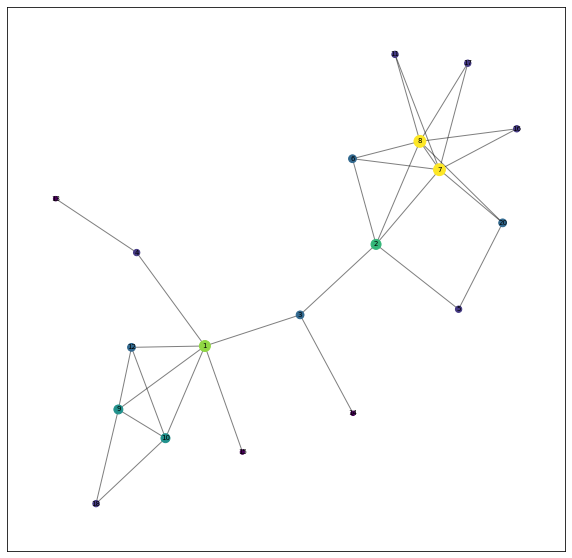

In [3]:
working_directory = os.getcwd()

sg.theme('SystemDefault1') 

right_symbol = "🡆"
down_symbol = "🡇"

def collapse(layout, key):
    # sg.pin allows us to display or hide whatever is inside (column)
    return sg.pin(sg.Column(layout, key = key))

def create_table(headers, data):
    
    network_info_layout = [
        [sg.Table(values=data, headings=headers, max_col_width = 35, expand_x = True, expand_y = True, auto_size_columns = True, justification = 'right', alternating_row_color = 'lightGrey', num_rows = 10, display_row_numbers = True, key = '-TABLE-', row_height = 35, tooltip = "Network's Table", enable_click_events = True)],       
        [sg.Button("Close")]
    ]
    
    network_table_window = sg.Window("Graph's Table", network_info_layout, modal = True, element_justification = 'center', resizable = True)
    
    while True:
        event, values = network_table_window.read()
        if event == 'Close' or event == sg.WIN_CLOSED:
            break
            
    network_table_window.close()
    


section_community_detection_algorithms = [
    [sg.Text('Louvain Algorithm', size = (19, 0)), sg.Button('Run', key = '-LOV-', button_color = 'White')],
]

section_community_detection_evaluations = [
    [sg.Text('Conductance', size = (19, 0)), sg.Button('Run', key = "-COND-",button_color = 'White')],
    [sg.Text('Modularity', size = (19, 0)), sg.Button('Run',key = "-MOD-", button_color = 'White')],
    [sg.Text('NMI', size = (19, 0)), sg.Button('Run',key = "-NMI-", button_color = 'White')]
]

section_link_analysis_techniques = [
    [sg.Text('Page Rank', size = (19, 0)), sg.Button('Run', key="-PR-" ,button_color = 'White')],
]

section_adjust_nodes_edges = [
    [sg.Text('Node Degree', size = (19, 0)), sg.Button('Run', key = "-ND-", button_color = 'White')],
    [sg.Text('Edge Weight', size = (19, 0)), sg.Button('Run', key = "-EW-", button_color = 'White')],
]

section_centrality_measures = [
    [sg.Text('Degree Centrality', size = (19, 0)), sg.Button('Run', key = "-DC-", button_color = 'White')],
    [sg.Text('Betweenness Centrality', size = (19, 0)), sg.Button('Run', key = "-BC-", button_color = 'White')],
    [sg.Text('Closeness Centrality', size = (19, 0)), sg.Button('Run', key = "-CC-", button_color = 'White')],
    [sg.Text('Eigenvector Centrality', size = (19, 0)), sg.Button('Run', key = "-EC-", button_color = 'White')],
]

col_1 = [
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDE-'), sg.Text("Community Detection Evaluations")],
    [collapse(section_community_detection_evaluations, '-SEC_CDE-')],
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_LA-'), sg.Text("Link Analysis Techniques")],
    [collapse(section_link_analysis_techniques, '-SEC_LA-')],
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_ANE-'), sg.Text("Adjust Nodes & Edges")],
    [collapse(section_adjust_nodes_edges, '-SEC_ANE-')]
]

col_2 = [
     [sg.Canvas(size=(800, 800), key = "-CANVAS-")]
]

col_3 = [
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CDA-'), sg.Text("Community Detection Algorithms")],
    [collapse(section_community_detection_algorithms, '-SEC_CDA-')],
    [sg.Text(down_symbol, font = ('Helvetica', 14), enable_events = True, key = '-OPEN_SEC_CM-'), sg.Text("Centrality Measures")],
    [collapse(section_centrality_measures, '-SEC_CM-')],
]

Grivan_layout = [
     [sg.Canvas(size=(500, 500), key = "-GRIVAN-")]
]

ov=[
    [sg.Column(Grivan_layout)]
]

overview_layout = [
   [sg.Col(col_1), sg.VerticalSeparator(), sg.Col(col_2), sg.VerticalSeparator(), sg.Col(col_3)]
]

data_laboratory_layout = [
    
    [sg.Text('Select the Nodes CSV file:')],
                      [sg.InputText(key='_NODES_FILE1_'), sg.FileBrowse(file_types=(("CSV Files", "*.csv"),))],
                      [sg.Text('Select the Edges CSV file:')],
                      [sg.InputText(key='_EDGES_FILE1_'), sg.FileBrowse(file_types=(("CSV Files", "*.csv"),))],
                      [sg.Checkbox('Directed', key='_DIRECTED_')],
                      [sg.Checkbox('Weighted', key='_WEIGHTED_')],
                      [sg.Button('Load Network',key = '-Load Network-'), sg.Button('Cancel')],
]

tab_group = [
    [sg.TabGroup(
                 [[
                     sg.Tab("Overview", overview_layout, background_color = 'White', element_justification = 'left'),
                     sg.Tab("Data Laboratory", data_laboratory_layout, background_color = 'White', element_justification = 'left')
                 ]],
                     tab_location = 'centertop',
                     title_color = 'White', 
                     tab_background_color = 'Grey', 
                     selected_title_color = 'Black',
                     selected_background_color = 'White',
                     border_width = 1
    ),
    
],
    [sg.Button('Exit', button_color = 'White')]
]

window = sg.Window('Mini Social Networks Analysis Tool', tab_group, finalize = True, resizable = True, element_justification = 'center')

opened_cda = True
opened_cde = True
opened_la = True
opened_ane = True
opened_cm = True

while True:
    event,values = window.read()
    if values is not None:
        nodes_filename = values['_NODES_FILE1_']
        edges_filename = values['_EDGES_FILE1_']
        directed = values['_DIRECTED_']
        weighted = values['_WEIGHTED_']
    if event == "Exit" or event == sg.WIN_CLOSED:
        break
    if event == '-OPEN_SEC_CDA-':
        opened_cda = not opened_cda
        window['-OPEN_SEC_CDA-'].update(down_symbol if opened_cde else right_symbol)
        window['-SEC_CDA-'].update(visible = opened_cda)
    if event == '-OPEN_SEC_CDE-':
        opened_cde = not opened_cde
        window['-OPEN_SEC_CDE-'].update(down_symbol if opened_cde else right_symbol)
        window['-SEC_CDE-'].update(visible = opened_cde)
    if event == '-OPEN_SEC_LA-':
        opened_la = not opened_la
        window['-OPEN_SEC_LA-'].update(down_symbol if opened_la else right_symbol)
        window['-SEC_LA-'].update(visible = opened_la)
    if event == '-OPEN_SEC_ANE-':
        opened_ane = not opened_ane
        window['-OPEN_SEC_ANE-'].update(down_symbol if opened_ane else right_symbol)
        window['-SEC_ANE-'].update(visible = opened_ane)
    if event == '-OPEN_SEC_CM-':
        opened_cm = not opened_cm
        window['-OPEN_SEC_CM-'].update(down_symbol if opened_cm else right_symbol)
        window['-SEC_CM-'].update(visible = opened_cm)

    if event == "-DET-" and nodes_filename !="" and edges_filename !="":
        data = pd.read_csv(values["-FILE_PATH_EDGES-"])
        data_arr = data.to_numpy()
        headers = data.columns.to_numpy()
        create_table(headers.tolist(), data_arr.tolist())
    if event == "-BC-" and nodes_filename !="" and edges_filename !="":
        G = load_network()
        bc_figure(G)
    if event == '-CC-' and nodes_filename !="" and edges_filename !="":
        G = load_network()

        cc_figure(G)
    if event == '-EC-'and nodes_filename !="" and edges_filename !="":
        G = load_network()
        ec_figure(G)
    if event == '-DC-'and nodes_filename !="" and edges_filename !="":
        G = load_network()
        dc_figure(G)
    if event == '-EW-' and nodes_filename !="" and edges_filename !="":
        edges_data = pd.read_csv(edges_filename)
        rows = edges_data.count()[0] # Returns the number of rows in the dataframe
        
        if 'Weight' or 'weight' not in edges_data.columns:
            edges_data['Weight'] = rows * [1]
        else:
            edges_data.rename(columns = {'weight':'Weight'}, inplace = True)
            
        G = nx.from_pandas_edgelist(edges_data, source='Source', target='Target', edge_attr='Weight', create_using=nx.MultiGraph())    
        
        G1 = nx.Graph()
        
        for u,v,data in G.edges(data=True):
            w = data['weight'] if 'weight' in data else 1.0
            if G1.has_edge(u,v):
                G1[u][v]['weight'] += w
            else:
                G1.add_edge(u, v, weight=w)
                
        #data_arr = edges_data.to_numpy()
        #G = nx.Graph()
        #G.add_edges_from(data_arr)
        ew_figure(G1)
    if event=='-Load Network-' and nodes_filename !="" and edges_filename !="":
        G = load_network()
        sg.popup('Network loaded successfully!', f'Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}')
        draw_figure(window["-CANVAS-"].TKCanvas, create_plot(G, 0))
    if event == '-ND-' and nodes_filename !="" and edges_filename !="":
        G = load_network()
        nd_figure(G)
    if event == '-PR-' and nodes_filename !="" and edges_filename !="":
        G = load_network()
        pr_figure(G)    
    if event == '-LOV-' and nodes_filename !="" and edges_filename !="":
        if directed:
            sg.popup("Louvain algorithm is not defined for directed graphs:",title="Popup Message")
        else:   
            G = load_network()
            lo_figure(G) 
        
    if event =='-MOD-' and nodes_filename !="" and edges_filename !="":
        if directed:
            sg.popup("Modularity is not defined for directed graphs:",title="Popup Message")
        else:    
            G = load_network()
            #nx.draw(G)
            #G = nx.from_pandas_edgelist(df, source="Source", target="Target")
            # Run the Louvain algorithm
            partition = community.best_partition(G)
            # print(partition)
            # Calculate the modularity
            modularity = community.modularity(partition, G)
            #print("Modularity:", modularity)
            sg.popup("Calculate the modularity:",modularity)
    if event=='-COND-' and nodes_filename !="" and edges_filename !="":
            #G = load_network()
            G = load_network()
            df_nodes = pd.read_csv(nodes_filename)

            # Load edges from CSV file
            df_edges = pd.read_csv(edges_filename)

            # Create a graph from the dataset
            G = nx.from_pandas_edgelist(df_edges, source="Source", target="Target")

            # Set node attributes
            node_attributes = df_nodes.set_index('ID').to_dict('index')
            nx.set_node_attributes(G, node_attributes)

            # Run the Louvain algorithm to partition the graph
            partition = community.best_partition(G)

            # Compute the conductance of each community
            conductances = []
            for com in set(partition.values()):
                # Get the nodes in the community
                nodes = [node for node in partition.keys() if partition[node] == com]
                # Compute the cut size
                cut_size = nx.cut_size(G, nodes)
                # Compute the volume of the community
                volume = sum(G.degree(node) for node in nodes)
                # Compute the conductance
                if volume == 0:
                    conductance = 1
                else:
                    conductance = cut_size / volume
                conductances.append(conductance)

            # Print the conductance of each community
            for i, c in enumerate(set(partition.values())):
                print("Community {}: Conductance = {:.4f}".format(i+1, conductances[i]))
            # Compute the average conductance
            avg_conductance = sum(conductances) / len(conductances)
            print("Average Conductance = {:.4f}".format(avg_conductance))
            sg.popup("Calculate the Average Conductance:",avg_conductance,title="My Popup Title")
    if event=='-NMI-' and nodes_filename !="" and edges_filename !="":
        # Load the dataset as a pandas dataframe
        df = pd.read_csv(edges_filename)

        # Create a graph from the dataframe using networkx
        G = nx.from_pandas_edgelist(df, source='Source', target='Target')

        # Apply Louvain clustering algorithm using the community module
        partition = community.best_partition(G)

        # Convert the partition dictionary to a list of labels
        labels = [partition.get(node) for node in G.nodes()]
        labels_pred = [partition[n] for n in G.nodes()]

        # Calculate NMI
        nmi = normalized_mutual_info_score(labels_pred, labels, average_method='arithmetic')
        #print("NMI based on Louvain algorithm: ", nmi)
        # Detect communities using the Louvain algorithm
        sg.popup("NMI based on Louvain algorithm:",nmi,title="My Popup Title")

    #else :
        #print("Choose a file path first")
    #print(nx.info(G))
    #nx.draw(G)
    #plt.show()
window.close()

In [4]:
import networkx as nx
from networkx.algorithms import community

# create a network
G = nx.karate_club_graph()

# detect communities based on modularity using the greedy algorithm
communities = community.greedy_modularity_communities(G)

# print the communities and their sizes
for i, c in enumerate(communities):
    print(f"Community {i+1}: {c}, size = {len(c)}")


Community 1: frozenset({8, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33}), size = 17
Community 2: frozenset({1, 2, 3, 7, 9, 12, 13, 17, 21}), size = 9
Community 3: frozenset({0, 16, 19, 4, 5, 6, 10, 11}), size = 8


In [1]:
!pip install python-louvain
